# Universidad Autónoma de Nuevo León.

## Facultad de Ingnieria Mecánica y Eléctrica.

### Tópicos Selectos de Ciencias de la Ingenieria III: Mineria de Datos

### Algorítmos Genéticos.

| Nombre | Matricula |
| -:- | -:- |
| Diego Rafael Gil Meza | 1722777 |

---
### ¿Qué son los Algoritmos Genéticos?
Los algoritmos genéticos son algoritmos de optimización inspirados en la selección natural y la genética, una de las ventajas con los algoritmos genéticos es que pueden ser implementados en una gran cantidad de problemas de optimización.

El algoritmo es simple de entender y de implementar, lo cual facilita el mantenimiento de este, los algoritmos geneticos tienen la siguiente estructura base:
1. Una población con soluciones iniciales.
2. Una medida de optimidad.
3. Una forma de mezclar los genes de la población.
4. Una forma de mutar dichos genes.

Esta serie de requisitos es necesaria para que el algoritmo genetico pueda encontrar las soluciones optimas a los problemas dados, una de las ventajas de los algoritmos genéticos es que pueden ser usados en espacios de busqueda complejos, así como tener multiples soliciones iniciales, evitando así el problema del óptimo local.

Los Algoritmos genéticos hacen uso de un conjunto de operadores genéticos, los cuales describen funciones base de la metodología, los tres más importantes son los siguientes:
1. Seleccion: La selección Busca simular la selección natural, una competencia enrte la población para saber cuales individuos son los más aptos para pasar los genes a la siguiente generación.
2. Cruce: Simula la reproducción sexual, intercambiando la información genetica a la siguiente población.
3. Mutación: Simula la mutación de los genes, esto para escapar de posibles optimos locales.

Como se puede inducir hasta este punto, el espacio de busqueda de los algoritmos genéticos son los genes del individuo, estos genes son vectores de bits que representan una posible solución para el problema dado, la longitud de los genes es proporcional a la posible solución del problema.

---
### Ejemplo: Problema de modelado lineal con AG.

Dado una función `F(x) = x^2; 0 <= x <= 4095`

Lo primero es entender las restricciones:
`x >= 0`
` x < 4096`

Lo siguiente es encontrar una forma de convertir el espacio de busqueda de enteros a binarios, una forma puede ser pasar de decimal a binario al numero 4096.

`bin(4096) = 11111111111`

Ahora definimos una funcion de aptitud en la que:
`if x > 4096 return 0 else return x**2`

dado que para x es imposible que sea menor que 0, entonces esta medida cumple con las restricciones, por útimo codificamos el algoritmo genético.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def conteo():
    i = 11
    while True:
        i += 1
        yield i

Hasta este punto, unicamente importamos las librerias que usaremos, numpy, pandas, matplotlib.

Lo siguiente es crear los operadores genéticos, el primer operador que crearemos sera el de generar una población, ya que es conciderado un operador, el operador realizara lo siguiente:
1. Crear una población de N individuos con M genes, los cuales seran inicializados en estados aleatorios.

In [2]:
def inicializar_poblacion(N, M):
    # Crea una poblacion inicial de N individuos con M genes.
    poblacion = {}

    # Por cada gen del individuo.
    for i in range(M):
        poblacion[i] = []

        # Por cada individuo en la poblacion.
        for j in range(N):
            # Asigna el gen aleatoriamente.
            poblacion[i].append(np.random.randint(0, 2))

    return pd.DataFrame(
        poblacion,
        index=['ID_{}'.format(i) for i in range(N)]
    )

El siguiente operador es el de selección, lo que busca realizar este operador es lo siguiente:
1. Una forma de competencia para determinar los mejores individuos.
2. Crear parejas para el operador genetico de cruce.
3. Descartar aquellos individuos no aptos.

Esto se puede lograr a partir del metodo de la ruleta. El método de la rutela indica que aquellos individuos con mayor aptitud tienen más probabilidad de encontrar pareja que aquellos con menor aptitud.

Antes de definir el operador de selección, es necesario definir la medida de aptitud.

In [3]:
def calcular_aptitud(individuo):
    # La aptitud se calcula combirtiendo el vector de bits a
    # decimal y despues usando la función a optimizar para
    # saber su valor en F(x).
    aptitud = 0

    i = len(individuo) - 1
    for gen in individuo:
        if gen == 1:
            aptitud += 2**i

        i -= 1

    if aptitud > 4095:
        return 0

    return aptitud**2

In [4]:
def aptitud_poblacion(poblacion):
    # Calculamos las aptitudes de la población.
    aptitudes = {}
    for id in poblacion.index:
        individuo = poblacion.loc[id]
        aptitudes[id] = calcular_aptitud(individuo)

    aptitudes = pd.Series(aptitudes)
    
    aptitudes.sort_values(ascending=False, inplace=True)

    return aptitudes

Ahora podemos definir el operador de selección.

In [5]:
def seleccion(poblacion):
    parejas = []
    
    # Ahora calculamos la probabilidad de la ruleta por individuo.
    aptitudes = aptitud_poblacion(poblacion)
    aptitud_pobalcion = sum(aptitudes)
    probabilidades = aptitudes / aptitud_pobalcion
    
    # Por último generamos las parejas con la ruleta.
    total_parejas = int(len(probabilidades.index)) / 2
    while total_parejas > 0:
        parejas.append(np.random.choice(
            probabilidades.index,
            2,
            replace=False,
            p=probabilidades
        ))

        total_parejas -= 1

    return parejas

Lo siguiente es definir el operador de cruce, el operador de cruce busca satisfacer estos criterios:
1. Realizar el intercambio de información y pasarlo a la siguiente generación
2. Implementar una estrategia de cruce de información, usualmente es implementador punto medio.

In [6]:
def cruce(parejas, poblacion, asignar_id):
    nueva_poblacion = {}
    
    # Por cada pareja en la lista de parejas.
    for id_a, id_b in parejas:
        
        # Se consultan los genes de los individuos.
        individuo_a = poblacion.loc[id_a].to_numpy()
        individuo_b = poblacion.loc[id_b].to_numpy()
        
        # Se calcula el index del punto medio del genoma.
        punto_medio = int(len(individuo_a) / 2)

        # Se realiza el intercambio de información
        # genetica y se crean dos sucesores.
        nueva_poblacion['ID_{}'.format(asignar_id.__next__())] = np.array(
            np.concatenate(
                (individuo_a[:punto_medio], individuo_b[punto_medio:]),
                axis=0
            )
        )

        nueva_poblacion['ID_{}'.format(asignar_id.__next__())] = np.array(
            np.concatenate(
                (individuo_b[:punto_medio], individuo_a[punto_medio:]),
                axis=0
            )
        )

    return pd.DataFrame(
        nueva_poblacion.values(),
        index=nueva_poblacion.keys()
    )

El último operador a implementar es el de mutación, este operador simula la mutación de los genes que cambian los parametros y propiedades de los individuos, los criterios que busca satisfacer este operador son los siguientes:
1. Indicar de manera aleatoria si un individuo es candidato a recibir una mutación o no.
2. Indicar cual gen sera mutado aleatoriamente, la mutación es la verción negada del valor del gen.

In [7]:
def mutacion(
    nueva_poblacion,
    probabilidad_mutacion,
    probabilidad_mutacion_gen
):
    # Por cada individuo en la nueva generacion.
    for id_individuo in nueva_poblacion.index:
        # Calculamos si el individuo es candidato a recibir una mutación.
        if np.random.random() <= probabilidad_mutacion:
            individuo = nueva_poblacion.loc[id_individuo]

            # Una vez que el individuo es apto para recibir
            # una mutación checamos cuales son los genes que mutaran.
            for i in individuo.index:
                # Calculamos si el gen tendra una mutación.
                if np.random.random() <= probabilidad_mutacion_gen:
                    # En este caso, en la mutación, el
                    # gen se cambia a su valor negado.
                    individuo[i] = int(not individuo[i])

    return nueva_poblacion

Lo siguiente es implementar el AG como tal, el pseudocodigo de los AG basicos es el siguiente:
```
DEFINE SELECCION:
    PARAMS:
        - P: Población en la que se realizara el proceso de selección.
        - FA: Función de Aptitud.
        - DECO: Funcion de decodificación del genoma.
        - LS: Longitudes de las secciones del genoma.

    LET decodificaciones <- DECO(P, LS)
    LET aptitudes <- FA(decodificaciones)
    LET ruleta <- aptitudes / SUM(aptitudes)

    LET parejas <- EMPTY LIST
    FOR EACH individuo IN P DO
        LET pareja <- WEIGHT_SELECT(ruleta)
        parejas.push(
            individuo,
            pareja
        )

    RETURN parejas

DEFINE CRUCE:
    PARAMS:
        - P: Población en la que se realizara el proceso de selección.
        - Pa: Parejas de los cruces.
        - LS: Longitudes de las secciones del genoma.

    LET nueva_pobacion <- NEW POBLACION()

    FOR EACH pareja in Pa DO
        LET pa_1, pa_2 <- pareja

        LET hijo_1 <- NEW INDIVIDUO()
        LET hijo_2 <- NEW INDIVIDUO()

        nueva_seccion_1, nueva_seccion_2 = CRUZAR_GENOMA(
            pa_1.genoma,
            pa_2.genoma, 
            LS
        )
        hijo_1.add_to_genoma(nueva_seccion_1)
        hijo_2.add_to_genoma(nueva_seccion_2)

        nueva_poblacion.add(hijo_1)
        nueva_poblacion.add(hijo_2)

    RETURN nueva_poblacion

DEFINE CRUZAR_GENOMA:
    PARAMS:
        - g_1: Genoma 1
        - g_2: Genoma 2
        - LS: Longitudes de las secciones del genoma.
        
    LET nuevo_g_1 = GENOMA()
    LET nuevo_g_2 = GENOMA()

    LET i = 0
    FOR long_seccion IN LS DO
        LET punto_medio = i + ROUND(long_seccion / 2)
        nuevo_g_1.add(
            g_1[i:punto_medio],
            g_2[punto_medio:i+long_seccion]
        )
        nuevo_g_2.add(
            g_2[i:punto_medio],
            g_1[punto_medio:i+long_seccion]
        )
        i += long_seccion

    RETURN nuevo_g_1, nuevo_g_2

DEFINE MUTACION:
    PARAMS:
        - P: Población en la que se realizara el proceso de mutacion.
        - PM: Probabilidad de mutación del individuo.
        - PMg: Probabilidad de mutación de cada gen.

    FOR EACH individuo IN P DO
        IF RANDOM() <= PM DO
            FOR EACH gen IN individuo.genoma DO
                IF RANDOM() <= PMg DO
                    gen.flip()

DEFINE AG:
    PARAMS:
        - Pi: Población inicial de algoritmo genetico.
        - LS: Longitudes de las secciones del genoma.
        - FA: Función de aptitud.
        - PM: Probabilidad de mutación del individuo.
        - PMg: Probabilidad de mutación de cada gen.
        - MAXi: Maxima cantidad de iteraciones.
        - DECO: Función de decodificación del genoma.

    LET longitud_genoma = SUM(LS)

    LET poblacion <- POBLACION_INICIAL(
        Pi,
        longitud_genoma
    )

    LET i = 0
    while i < MAXi DO
        LET parejas <- SELECCION(
            poblacion,
            FA,
            DECO,
            LS
        )

        LET nueva_poblacion <- CRUCE(
            poblacion,
            parejas,
            LS,
        )

        MUTACION(
            nueva_poblacion,
            PM,
            PMg,
        )

        poblacion = nueva_pobacion
        i ++
```

In [8]:
def AG(
    long_poblacion_inical,
    long_genoma,
    i_max,
    p_mutacion,
    p_mutacion_gen,
):
    asignar_id = conteo()
    poblacion = inicializar_poblacion(long_poblacion_inical, long_genoma)
    
    aptitudes = aptitud_poblacion(poblacion)
    aptitud_prom = sum(aptitudes) / len(aptitudes)
    
    optimo = aptitudes[aptitudes.index[0]]
    
    yield aptitud_prom, optimo

    i = 0
    while i < i_max and len(poblacion) > 1:
        parejas = seleccion(poblacion)
        nueva_poblacion = cruce(parejas, poblacion, asignar_id)
        poblacion = mutacion(nueva_poblacion, p_mutacion, p_mutacion_gen)
        
        aptitudes = aptitud_poblacion(poblacion)
        aptitud_prom = sum(aptitudes) / len(aptitudes)
        
        if aptitudes[aptitudes.index[0]] > optimo:
            optimo = aptitudes[aptitudes.index[0]]

        i += 1
        
        yield aptitud_prom, aptitudes[aptitudes.index[0]]

Ahora implementamos todos los operadores y funciones en una función main.

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
aptitud_prom,6247401.4,10517721.3,12479356.9,13971169.3,15237154.0,13621218.1,14046496.1,13267342.15,14338785.2,14035445.6,...,13817677.4,14027424.0,15626210.85,15086255.25,15235455.2,15322133.2,15200856.55,15895205.8,15615990.95,15587614.05
optimo,16289296.0,16548624.0,16654561.0,16548624.0,16548624.0,16548624.0,16524225.0,16386304.00,16524225.0,16443025.0,...,16394401.0,16394401.0,16394401.00,16394401.00,16394401.0,16394401.0,16394401.00,16394401.0,16654561.00,16654561.00


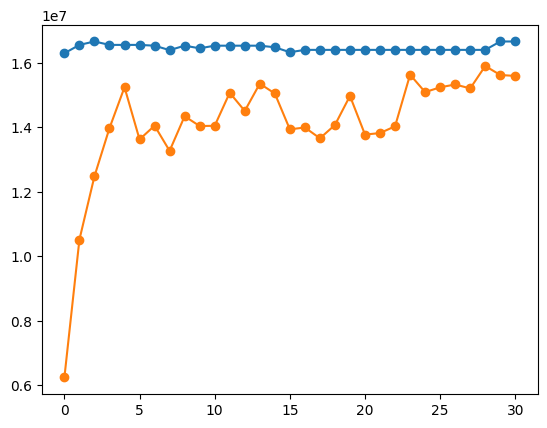

'Mejor valor: 16654561.0'

In [9]:
def main():
    ag = AG(20, 12, 30, 0.2, 0.1)
    
    historico = {}
    
    i = 0
    for aptitud_prom, optimo in ag:
        historico[i] = {
            'aptitud_prom': aptitud_prom,
            'optimo': optimo
        }
        i += 1
        
    historico = pd.DataFrame(historico)
    display(historico)
    
    plt.plot(
        [i for i in range(len(historico.loc['optimo']))],
        historico.loc['optimo'],
        'o-'
    )
    plt.plot(
        [i for i in range(len(historico.loc['aptitud_prom']))],
        historico.loc['aptitud_prom'],
        'o-'
    )
    plt.show()
    
    display(
        'Mejor valor: {}'.format(historico.loc['optimo'].max())
    )

if __name__ == '__main__':
    main()